# Yelp Data Challenge - NLP
We will build a sentiment analysis system for the review texts. Such a system would be useful in pinpointing difficulties encountered by businesses --- or their successes, for that matter. Useful, when we don't have time to comb through many reviews.

In this project, we will simulate encountering new data with a heldout test set.

## Load data
We will use the DataFrame constructed in `Data_Preprocessing.ipynb`. It contains reviews of restaurants from Las Vegas from approximately the last 2 years.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [2]:
df = pd.read_csv('data/last_2_years_restaurant_reviews.csv')
df.head(3)

,business_id,name,categories,avg_stars,attributes,cool,date,funny,review_id,stars,text,useful,user_id
0,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",0,2017-04-01,0,Spl0fx_X6bjPASU-zUJQUA,1,"Ordered a pizza, the location is literally in ...",1,vZ-eQzpCOrSWfBfU5KUvIA
1,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",0,2016-11-20,0,2UV-a8pXUdbK0fdurFwXfQ,5,Very busy place but they take good care of you...,0,nu6wU6PLbL9HPLZuqon0-A
2,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",0,2018-03-27,0,vG5m3TzOf5F52jzO2D_19g,3,Stopped here to pick up an order of wings on m...,0,KEerqlFNhzl1I-yVK6mHVA


In [3]:
# Minor number of NAs in 'attributes'; fortunately, we won't need that feature
pd.DataFrame.sum(df.isna())

business_id     0
name            0
categories      0
avg_stars       0
attributes     84
cool            0
date            0
funny           0
review_id       0
stars           0
text            0
useful          0
user_id         0
dtype: int64

### Extract review texts

In [4]:
# Take the values of the column that contains review text data, save to a variable named "documents"
documents = df.text

There are 101569 reviews in total.
Sample: Ordered a pizza, the location is literally in front of my apartment complex and my pizza was cold. Must have been sitting there for for almost an hour for as cold as it was, the drive from this location to my apartment door is all of anout five minutes. I ordered a soda and its
obvious it was never placed in a fridge. Cold pizza and warn soda. Horrible!


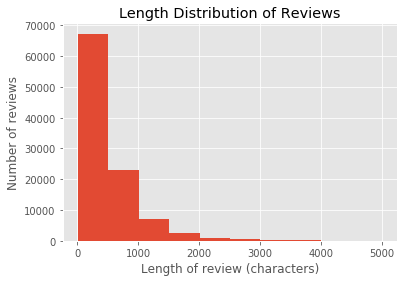

In [5]:
'''
    Inspect documents --- check length, and display example.
    
    We see that reviews come in various lengths. Deep learning approaches using RNNs may work,
    but it would be quite troublesome/RAM-consuming to pad/cut the reviews to an appropriate, uniform length.
    Therefore, we will adopt a bag-of-words approach, to acceptable results
'''

plt.hist(documents.apply(len))
plt.title("Length Distribution of Reviews")
plt.ylabel("Number of reviews")
plt.xlabel("Length of review (characters)")

print("There are {} reviews in total.".format(len(documents)))
print("Sample: {}".format(documents[0]))

### Define target variable

Let's distinguish between perfect (5 stars) and imperfect (1-4 stars) ratings. The assumption is that if a user gives a rating lower than 4, then there are potential room for improvements!

In [6]:
# Make a column and take the values, save to a variable named "target"
target = df.stars
target = (target == 5) #True if perfect
target = target.astype('int')

In [7]:
# Fortunately, target variable is almost balanced. 
target.value_counts()

0    52978
1    48591
Name: stars, dtype: int64

## Splitting into training and test sets

In [8]:
from sklearn.model_selection import train_test_split

In [15]:
# Documents is your X, target is your y
# Now split the data `to training set and test set
# Split to documents_train, documents_test, target_train, target_test --- use the (default) 75-25 split

documents_train, documents_test, target_train, target_test = train_test_split(documents, target, 
                                                                              test_size=0.25,
                                                                              random_state=43)

## Obtain NLP representation of `documents`

Term frequency–inverse document frequency (Tf-idf) representation of single words is used here.

We are **NOT** going to filter out the NLTK stopwords, because some of them may indicate sentiment: 'don't', 'weren't' ... basically, grammatical constructs that may be useful for our task.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

In [17]:
print(stopwords.words('english')) 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [18]:
# Create TfidfVectorizer, and name it vectorizer
vectorizer = TfidfVectorizer()

In [19]:
# Fit the vectorizer with training data
vectorizer.fit(documents_train)
X_train = vectorizer.transform(documents_train)

# Use the trained vectorizer to transform test data
X_test = vectorizer.transform(documents_test)

In [20]:
# Get the vocab of your tfidf
vocab = vectorizer.vocabulary_
print("Vocabulary contains {} items".format(len(vocab)))

Vocabulary contains 49072 items


## Build Search Engine for 'Similar' Reviews
Once we have identified a review as positive/negative, we may want to search for other similar reviews to get a better picture of the data or the restaurant(s). Here, similarity is calculated based on Tf-idf features, and experimentally cosine similarity proves to give reasonable results.

From experience working with word embeddings

In [21]:
import numpy as np

# Helper functions for selecting search engine results 

def get_top_values(lst, n, labels):
    '''
    INPUT: LIST, INTEGER, LIST
    OUTPUT: LIST

    Given a list of values, find the indices with the highest n values.
    Return the labels for each of these indices.

    e.g.
    lst = [7, 3, 2, 4, 1]
    n = 2
    labels = ["cat", "dog", "mouse", "pig", "rabbit"]
    output: ["cat", "pig"]
    '''
    return [labels[i] for i in np.argsort(lst)[::-1][:n]]  # np.argsort by default sorts values in ascending order

def get_bottom_values(lst, n, labels):
    '''
    INPUT: LIST, INTEGER, LIST
    OUTPUT: LIST

    Given a list of values, find the indices with the lowest n values.
    Return the labels for each of these indices.

    e.g.
    lst = [7, 3, 2, 4, 1]
    n = 2
    labels = ["cat", "dog", "mouse", "pig", "rabbit"]
    output: ["mouse", "rabbit"]
    '''
    return [labels[i] for i in np.argsort(lst)[:n]]

In [22]:
# Test helper functions from above
print( get_bottom_values(lst=[7, 3, 2, 4, 1], n=2, labels = ["cat", "dog", "mouse", "pig", "rabbit"]) ) 
print( get_top_values(lst=[7, 3, 2, 4, 1], n=2, labels = ["cat", "dog", "mouse", "pig", "rabbit"]) )

['rabbit', 'mouse']
['cat', 'pig']


In [23]:
# Let's use cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

In [24]:
# Draw an arbitrary review from test (unseen in training) documents
review_ind = 2103
review = X_test[review_ind, :]

(array([3.794e+03, 2.147e+04, 3.202e+04, 1.552e+04, 2.781e+03, 3.990e+02,
        1.180e+02, 5.600e+01, 1.400e+01, 4.000e+00]),
 array([0.        , 0.04309329, 0.08618658, 0.12927988, 0.17237317,
        0.21546646, 0.25855975, 0.30165304, 0.34474634, 0.38783963,
        0.43093292]),
 <a list of 10 Patch objects>)

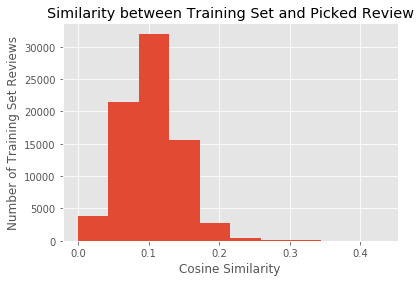

In [25]:
# Calculate the similarity score(s) between vector(s) and training vectors
similarity = cosine_similarity(X_train, review)
similarity = similarity.reshape(len(similarity),)

# Cosine similarity ranges from abs(0, 1)
# But even the top values are rather close to 0 ... Expect mediocre results
plt.title("Similarity between Training Set and Picked Review")
plt.ylabel("Number of Training Set Reviews")
plt.xlabel("Cosine Similarity")
plt.hist(similarity)

In [28]:
# Let's find top 4 similar reviews
top_similar_reviews = get_top_values(lst=similarity, n=4, labels=documents_train.values)

In [29]:
print('Our search query:')
print(documents_test.iloc[review_ind]) 
print()

print('Most %s similar reviews:' % len(top_similar_reviews))
for i, review in enumerate(top_similar_reviews):
    print("___ Review {} ___".format(i+1))
    print(review)
    print("___END___\n")

Our search query:
First time here and I love it!!! the service was good and friendly. The food was delicious. I recommend the chicken curry with bone and the goat curry. ask for Anthony for a great service. plus they have fresh naan!!! yummy. whenever in las vegas and you like Indian food this is the palace to go.

Most 4 similar reviews:
___ Review 1 ___
Very good! We love chicken katsu curry. The flavor of the curry was what we expected and can pick 1-10. We also ordered naan bread and cheese with the curry. Chicken was fresh and juicy. The rice was sticky and just made.
___END___

___ Review 2 ___
First off, Indian food inside of a hotel? All you have to do is to go down to the food court and order them. I love the idea already. 

This Indian food place located inside of the Venetian hotel, which is a very nice hotel. 

My husband ordered chicken curry for me one night and asked the cook to make the curry spicier. They did a good job . The curry was really tasty and the portion was 

* Q: Do the results make sense?

* A: It seems we are lucky with the particular review picked. All the top similar reviews discuss Indian restaurants
and their curries; two of them also discussed the taste of the chicken served. Cannot guarantee globally acceptable performance, but don't have better (and simple) ideas now.

## Classifying positive/negative review

Using logistic regression as a baseline; being able to interpret its coefficients help us understand the data better. Then, build random forest to achieve max prediction performance; tune with cross-validation.

We will use accuracy as our metric, because classes are almost balanced.

#### Logistic Regression Classifier

In [30]:
# Build a Logistic Regression Classifier

from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver="lbfgs", max_iter=500)
lr_clf.fit(X_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [31]:
# Get mean accuracy for training set
lr_clf.score(X_train, target_train)

0.8714949590422181

In [32]:
# Get mean accuracy for test set. 
# Not bad! Let's hope RandomForest can beat LR; if not, LR works well enough anyway.
lr_clf.score(X_test, target_test)

0.847280746662466

#### Q: What are the features (words) that tend to produce a positive prediction?

The top 20 features (i.e. with "large" positive coefficients) are all adjectives/adverbs of praise! Wonderful :)

In [33]:
# Must first create a mapping from feature index to actual word
ix_to_words = {ix:word for word,ix in vocab.items()}

In [34]:
top_positive_words = get_top_values(lst=lr_clf.coef_[0], n=20, labels=ix_to_words)
print(top_positive_words)

['amazing', 'best', 'awesome', 'delicious', 'excellent', 'incredible', 'fantastic', 'perfect', 'thank', 'highly', 'great', 'love', 'favorite', 'die', 'bomb', 'perfectly', 'outstanding', 'perfection', 'everything', 'phenomenal']


#### Q: What are the features (words) that tend to produce the negative prediction?

Glad to see that words of criticism tend to produce negative predictions!

In [35]:
top_negative_words = get_bottom_values(lst=lr_clf.coef_[0], n=20, labels=ix_to_words)
print(top_negative_words)

['worst', 'horrible', 'ok', 'rude', 'okay', 'terrible', 'not', 'disappointing', 'bland', 'slow', 'however', 'decent', 'mediocre', 'average', 'but', 'disgusting', 'dry', 'overpriced', 'wasn', 'poor']


## Use grid search to find best predictable classifier

Tuning the random forest took a lot of time; unfortunately, there is still significant overfitting, and the model performance is *worse* than logistic regression.

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from math import sqrt, log2

In [38]:
rf_paramgrid = {
    'max_depth': (30,),
    'n_estimators': (55, 65),
    'max_features': int(sqrt(X_train.shape[1])) * np.array([10.0, 15.0, 20.0], dtype='int'),
}

grid_rf = GridSearchCV(cv=3, 
                       estimator=RandomForestClassifier(), 
                       param_grid=rf_paramgrid, 
                       scoring='accuracy', n_jobs=4)

grid_rf.fit(X_train, target_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': (30,), 'n_estimators': (55, 65), 'max_features': array([2210, 3315, 4420])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [39]:
print("After 3-fold CV, Random Forest achieves an accuracy of {}".format(grid_rf.best_score_))
print("The training accuracy is {}".format(grid_rf.score(X_train, target_train)))

After 3-fold CV, Random Forest achieves an accuracy of 0.8063957151858853
The training accuracy is 0.9474506406217181


### Reduce dimensions of training data using PCA, to overcome overfitting
As we can see from above, random forest is overfitting on the training data. Let's try reducing data dimensions using PCA, and fit random forest on the transformed set; hopefully that helps.

In [40]:
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score

In [41]:
# The maximum number possible of features
X_train.shape[1]

49072

In [42]:
# Using TruncatedSVD because it can work with sparse matrices directly
# Also, according to sklearn documentation, it is a common choice for working with Tf-idf matrices
pca = TruncatedSVD(n_components=50)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [43]:
# We will see that despite explaining so little of the variance, the model still mostly works
print(pca.explained_variance_ratio_.sum())

0.13844584312744154


In [54]:
# Build model; followed by a bit of hand-tuning
rf_pca = RandomForestClassifier(n_estimators=100, n_jobs=2, max_features='log2', max_depth=10)
rf_pca.fit(X_train_pca, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [55]:
# Training accuracy
print(rf_pca.score(X_train_pca, target_train))

# 3-fold CV accuracy
print(cross_val_score(rf_pca, X_train_pca, target_train, cv=3, scoring="accuracy"))

0.834173492963663
[0.78824873 0.78571991 0.78582962]


In [58]:
# Test performance
print(rf_pca.score(X_test_pca, target_test))

0.7932501082975624


Conclusion: it is amazing that despite retaining only 50 features out of 49072, our model performs basically just as well. Moreover, the model trained much more quickly. However, PCA itself did not reduce overfitting; I had to manually set a small `max_depth` so that the training accuracy goes down. 

All in all, it would take more hyperparameter tuning to build an excellent random forest. However, that would have to wait until I find a faster computer for doing so.